In [1]:
%config IPCompleter.use_jedi = False
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cvxpy as cp
import pandas as pd
np.set_printoptions(precision=4)

from pathlib import Path
fig_path = str(Path().absolute())+'/figures/hw4/'
print(fig_path)
data_path = str(Path().absolute())+'/hw4/data/'
print(data_path)

/home/zpyang/grad_courses/2021_spring/ece595_ml/figures/hw4/
/home/zpyang/grad_courses/2021_spring/ece595_ml/hw4/data/


# Exercise 3

3 a)
$$
J(\theta) = -\frac{1}{N} \sum_{n=1}^{N}[y_n \cdot \log h_{\theta}(x_n) + (1-y_n) \cdot \log(1-h_{\theta}(x_n))]\\
= -\frac{1}{N} \sum_{n=1}^{N}[y_n \cdot \log (\frac{h_{\theta}(x_n)}{1-h_{\theta}(x_n)}) + \log(1-h_{\theta}(x_n))]\\
= -\frac{1}{N} \{\sum_{n=1}^{N}[y_n \cdot \log (\frac{h_{\theta}(x_n)}{1-h_{\theta}(x_n)})] + \sum_{n=1}^{N}\log(1-h_{\theta}(x_n))\}
$$
where $h_{\theta}(x) = \frac{1}{1+\exp\{-\theta^Tx_n\}}$

Subbing $h_{\theta}(x)$ back into the loss function, we obtain
$$
J(\theta) = -\frac{1}{N} \{\sum_{n=1}^{N}[y_n \cdot \log (\frac{\frac{1}{1+\exp\{-\theta^Tx_n\}}}{1-\frac{1}{1+\exp\{-\theta^Tx_n\}})})] + \sum_{n=1}^{N}\log(1-\frac{1}{1+\exp\{-\theta^Tx_n\}})
\}\\
= -\frac{1}{N} \{\sum_{n=1}^{N}y_n\log(e^{-\theta^Tx_n}) + \sum_{n=1}^{N} \log(1-\frac{e^{\theta^Tx_n}}{1+e^{\theta^Tx_n})}
\}\\
= -\frac{1}{N} \{\sum_{n=1}^{N}-y_n\theta^Tx_n - \sum_{n=1}^{N}\log{(1+e^{\theta^Tx_n})}
\}\\
= -\frac{1}{N} \{(\sum_{n=1}^{N}-y_nx_n)^T\theta  - \sum_{n=1}^{N}\log{(1+e^{\theta^Tx_n})}
\}\\
$$

In [24]:
# 3 b)

c0 = pd.read_csv(data_path+"class0.txt", delimiter='\s+', header=None).to_numpy()
c1 = pd.read_csv(data_path+"class1.txt", delimiter='\s+', header=None).to_numpy()

n0 = c0.shape[0]
n1 = c1.shape[0]
N = n0 + n1
x = np.vstack([c0,c1])
y = np.hstack([np.zeros(n0), np.ones(n1)]).reshape(-1,1)
X = np.hstack([x, np.ones((N,1))])

lambd = 0.0001

theta = cp.Variable((3,1))
loss = -cp.sum(cp.multiply(y, X @ theta)) \
        + cp.sum(cp.log_sum_exp(cp.hstack([np.zeros((N,1)), X @ theta]), axis=1))
reg = cp.sum_squares(theta)
prob = cp.Problem(cp.Minimize(loss/N + lambd*reg))
prob.solve()
omega = theta.value

omega

array([[  2.3786],
       [  1.4975],
       [-10.4365]])

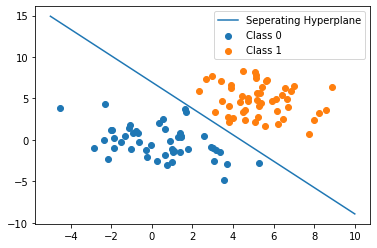

In [8]:
# 3 c)

x1 = np.linspace(-5,10,2)
x2 = -omega[0]/omega[1] * x1 - omega[2]/omega[1]

plt.figure
plt.scatter(c0[:,0], c0[:,1], label='Class 0')
plt.scatter(c1[:,0], c1[:,1], label='Class 1')
plt.plot(x1,x2, label='Seperating Hyperplane')
plt.legend()


In [9]:
# 3 d)
mu0 = c0.mean(0)
mu1 = c1.mean(0)

SIG0 = np.cov(c0.T)
SIG1 = np.cov(c1.T)

invSIG1 = np.linalg.inv(SIG1)
invSIG0 = np.linalg.inv(SIG0)
detSIG1 = np.linalg.det(SIG1)
detSIG0 = np.linalg.det(SIG0)

LOG0 = -0.5*np.log(detSIG0)
LOG1 = -0.5*np.log(detSIG1)

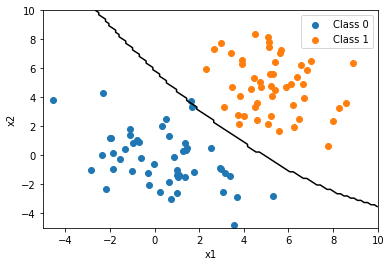

In [13]:
from tqdm.notebook import tqdm

x1 = np.linspace(-5,10,N)
x2 = np.linspace(-5,10,N)
X1,X2 = np.meshgrid(x1,x2)

grid = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        xi = np.array([X1[i,j], X2[i,j]]).T
        k0 = -0.5*(xi - mu0).T @ invSIG0 @ (xi - mu0) + LOG0
        k1 = -0.5*(xi - mu1).T @ invSIG1 @ (xi - mu1) + LOG1
        if k1 > k0:
            grid[i,j] = 1
plt.figure()
plt.contour(X1,X2,grid, levels=[0.5], cmap='gray')
plt.scatter(c0[:,0], c0[:,1], label='Class 0')
plt.scatter(c1[:,0], c1[:,1], label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

# Exercise 4

In [15]:
# 4 a)

h = 1
K = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        K[i,j] = np.exp(-np.sum((X[i,:]-X[j,:])**2)/h)
        
print('The 47th to 52th elements of the Kernel Matrix: \n', K[47:52, 47:52])

The 47:52 elements of the Kernel Matrix: 
 [[1.0000e+00 5.0531e-25 6.0654e-20 4.6547e-29 4.0689e-17]
 [5.0531e-25 1.0000e+00 3.9593e-13 2.6936e-33 5.3878e-12]
 [6.0654e-20 3.9593e-13 1.0000e+00 2.3035e-65 3.7842e-34]
 [4.6547e-29 2.6936e-33 2.3035e-65 1.0000e+00 2.1628e-06]
 [4.0689e-17 5.3878e-12 3.7842e-34 2.1628e-06 1.0000e+00]]


In [18]:
# 4 b)

alpha = cp.Variable((N,1))
loss = -cp.sum(cp.multiply(y, K @ alpha)) \
        + cp.sum(cp.log_sum_exp(cp.hstack([np.zeros((N,1)), K @ alpha]), axis=1))
reg = cp.quad_form(alpha, K)
prob = cp.Problem(cp.Minimize(loss/N + lambd*reg))
prob.solve()
a = alpha.value
print('The first 2 elements of alpha: ', a[0:2].T)

The first 2 elements of alpha:  [[-0.9525 -1.2105]]


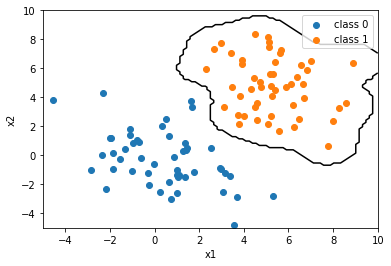

In [23]:
from numpy.matlib import repmat
out = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        data = repmat(np.array([x1[j], x2[i], 1]).reshape((1,3)), N, 1)
        phi = np.exp(-np.sum((X-data)**2, axis=1)/h)
        out[i,j] = np.dot(phi.T, a)

plt.figure()
plt.scatter(c0[:,0], c0[:,1], label='class 0')
plt.scatter(c1[:,0], c1[:,1], label='class 1')
plt.contour(x1, x2, out>0.5, levels=[0.5], cmap='gray')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()